# Create PQLD Nightly Epoch Lightcurves

PQLD = poor quality long duration

Contact: Melissa Graham

This notebook focuses on the candidates left behind which might still be useful:
poor quality (poor real/bogus scores) long-duration (repeated detections, less likely to be spurious).

PQLD candidates have >20 objects and a mean R/B score < 0.4. 

Results files:
 * all_nightly_epochs_files/PQLD_candidate_lightcurves.dat
 * all_nightly_epochs_files/PQLD_candidate_lightcurve_parameters.dat 

Columns are described in the file headers.

## 0. Set up

Import packages and connect to database.

In [1]:
import psycopg2
import psycopg2.extras
import getpass
import pandas

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from astropy.time import Time

from copy import deepcopy
import time

Use the username decat_ro, in order to access `versiontags`, and connect to database.

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")
db.autocommit = True
cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

DB User:  decat_ro
DB Password:  ········


If you want to print table schema.

In [ ]:
# tables = ['versiontags','exposures','subtractions','images',\
#           'objects','objectrbs','objectdatas','objectdata_versiontag','candidates']
# for table in tables:
#     query = "SELECT column_name, data_type FROM information_schema.columns WHERE table_name=%s"
#     cursor.execute( query, ( table, ))
#     print( f"\nTABLE: {table}\n===========================" )
#     for row in cursor:
#         print( f"{row['column_name']:24s}  :  {row['data_type']:s}" )

Use the `latest` version of the `versiontags`, and print the `tagid`.

The results in the database are tagged with versions so that data can be re-processed without
being overwritten, and so that different algorithms can be changed.

In [3]:
# tag = "latest"
tag = "default"  # as of Tue Feb 27 2024
db.rollback()
q = ( "SELECT id, tag FROM versiontags WHERE tag=%(tag)s" )
cursor.execute( q, { "tag": tag } )
row = cursor.fetchone()
tagid = row['id']
print(tagid)

2


## 1. Get all extragalactic-field objects

### 1.1. Query the database

Get all the objects in ELAIS and COSMOS fields, and print how many were retrieved.

This takes about a minute.

In [4]:
%%time
q = ("SELECT od.ra, od.dec, od.mag, od.magerr, rbs.rb, "
     "i.filter, i.meanmjd, o.candidate_id, e.proposalid "
     "FROM objectdatas AS od "
     "INNER JOIN objectdata_versiontag AS odvt "
     "ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
     "INNER JOIN objects AS o ON od.object_id=o.id "
     "INNER JOIN images AS i ON o.image_id=i.id "
     "INNER JOIN objectrbs as rbs ON od.id=rbs.objectdata_id AND rbs.rbtype_id=2 "
     "INNER JOIN exposures AS e ON i.exposure_id=e.id "
     "WHERE ((od.ra > 147.0 AND od.ra < 153.0 AND od.dec > -0.25 AND od.dec < 5) "
     "OR (od.ra > 5.0 AND od.ra < 12.0 AND od.dec > -46 AND od.dec < -41)) ")
cursor.execute(q, {'tagid': tagid})
df = pandas.DataFrame(cursor.fetchall())
print(len(df))

3123954
CPU times: user 17.3 s, sys: 2.62 s, total: 19.9 s
Wall time: 40 s


Put the objects into numpy arrays.
Prefix them with `raw_` because we will be reducing the contents.

In [5]:
raw_obj_ra     = np.asarray(df[0], dtype='float')
raw_obj_dec    = np.asarray(df[1], dtype='float')
raw_obj_mag    = np.asarray(df[2], dtype='float')
raw_obj_mage   = np.asarray(df[3], dtype='float')
raw_obj_rb     = np.asarray(df[4], dtype='float')
raw_obj_filt   = np.asarray(df[5], dtype='str')
raw_obj_mjd    = np.asarray(df[6], dtype='float')
raw_obj_candid = np.asarray(df[7], dtype='str')
raw_obj_propid = np.asarray(df[8], dtype='str')
del df

### 1.2. Identify PQLD candidates

#### 1.2.1. Delete all objects of candidates with 60 or less objects.

Recall that each field gets 5 exposures per filter per night.

So any decently well-detected candidate would have 15 objects per night.

This is a limit of 3 nights.

In [6]:
values, indices, inverse, counts = np.unique(raw_obj_candid, return_index=True, 
                                             return_inverse=True,  return_counts=True)

In [7]:
dx = np.where(counts[inverse] < 60)[0]

obj_ra     = np.delete(raw_obj_ra, dx)
obj_dec    = np.delete(raw_obj_dec, dx)
obj_mag    = np.delete(raw_obj_mag, dx)
obj_mage   = np.delete(raw_obj_mage, dx)
obj_rb     = np.delete(raw_obj_rb, dx)
obj_filt   = np.delete(raw_obj_filt, dx)
obj_mjd    = np.delete(raw_obj_mjd, dx)
obj_candid = np.delete(raw_obj_candid, dx)
obj_propid = np.delete(raw_obj_propid, dx)

print('Number of objects deleted: ', len(dx))
print('As a fraction of current number of objects: ', np.round(len(dx)/len(raw_obj_ra), 2))
print('Number of objects remaining: ', len(obj_ra))

del dx
del raw_obj_ra, raw_obj_dec, raw_obj_mag, raw_obj_mage
del raw_obj_rb, raw_obj_filt, raw_obj_mjd, raw_obj_candid, raw_obj_propid
del values, indices, inverse, counts

Number of objects deleted:  2611016
As a fraction of current number of objects:  0.84
Number of objects remaining:  512938


Get the number of unique candidates now.

In [8]:
values, indices, inverse, counts = np.unique(obj_candid, return_index=True, 
                                             return_inverse=True, return_counts=True)

In [9]:
print('Number of candidates: ', len(values))

Number of candidates:  3576


In [10]:
print('On average, %4.2f objects per candidate' % (len(obj_candid)/len(values)))

On average, 143.44 objects per candidate


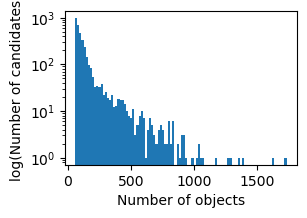

In [11]:
fig = plt.figure(figsize=(3, 2))
plt.hist(counts, bins=100, log=True)
plt.xlabel('Number of objects')
plt.ylabel('log(Number of candidates)')
plt.show()

#### 1.2.2. Delete candidates with mean R/B > 0.4

Create temporary arrays to hold candidate info:

```
cand_ids    : list of unqiue candidates
cand_nobjs  : number of objects per candidate
cand_meanrb : mean R/B score for candidates' objects
```

In [12]:
tmp_cand_ids = values
tmp_cand_nobjs = counts
tmp_cand_meanrb = np.zeros(len(tmp_cand_ids), dtype='float')

Calculate the mean R/B score for each candidate, `cand_mrb`.

This takes about 1 minute.

In [13]:
%%time
t0 = time.time()
for c, cid in enumerate(tmp_cand_ids):
    if (c == 100) | (c == 1000) | (c == 10000):
        t1 = time.time()
        print('c = %5i, elapsed = %5.1f seconds' % (c, t1 - t0))
        del t1
    cx = np.where(obj_candid == cid)[0]
    tmp_cand_nobjs[c] = len(cx)
    tmp_cand_meanrb[c] = np.nanmean(obj_rb[cx])
    del cx

c =   100, elapsed =   0.2 seconds
c =  1000, elapsed =   2.6 seconds
CPU times: user 9.23 s, sys: 3.18 ms, total: 9.23 s
Wall time: 9.23 s


Delete candidates with a mean R/B score > 0.4 from the candidate arrays.

In [14]:
dx = np.where(tmp_cand_meanrb > 0.4)[0]

cand_ids = np.delete(tmp_cand_ids, dx)
cand_nobjs = np.delete(tmp_cand_nobjs, dx)
cand_meanrb = np.delete(tmp_cand_meanrb, dx)

print('Number of candidates deleted: ', len(dx))
print('As a fraction of current number of candidates: ', np.round(len(dx)/len(tmp_cand_ids), 2))
print('Number of candidates remaining: ', len(cand_ids))

del dx
del tmp_cand_ids, tmp_cand_nobjs, tmp_cand_meanrb

Number of candidates deleted:  909
As a fraction of current number of candidates:  0.25
Number of candidates remaining:  2667


## 3. Create PQLD candidate nightly-epoch lightcurves

"Nightly-epoch" means all observations per filter per candidate in a given 
night are combined into a single photometry point.

Although we have limited only to candidates with mean R/B scores over
*all* objects are > 0.4, an individual nightly-epoch might have a mean R/B < 0.4.

### 3.1. Combine photometry into nightly-epochs

Use lists, first, and prefix with `tmp`.
Then store results in numpy arrays.

```
ne_candid : candidate id
ne_field  : field (COSMOS or ELAIS)
ne_cal    : calendar date
ne_mjd    : modified julian date
ne_fil    : filter (g, r, i)
ne_nobj   : number of objects combined
ne_mag    : combined magnitude
ne_mage   : combined magnitude error
ne_mrb    : mean R/B score of combined objects
```

Set up the array of unique MJDs and unique calendar dates.

Use every MJD since January 1 2021 as the set of unique mjds (umjd). JD = 2459215.5, MJD = 59215.0.

Use this range for combining into a nightly epoch: $umjd - 0.1 < mjd < umjd + 0.5$.

For the associated calendar date ("local night of"), use $umjd - 0.1$ as calendar date.

In [15]:
umjds = 59216.0 + np.arange(1000, dtype='float')
# print(umjds)

In [16]:
temp1 = 59216.0 + np.arange(1000, dtype='float') - 0.1
temp2 = Time(temp1, format='mjd')
temp3 = []
for t in range(len(temp2)):
    temp4 = temp2[t].isot
    temp3.append(temp4[0:10])
    del temp4
ucals = np.asarray(temp3, dtype='str')
del temp1, temp2, temp3
# print(ucals)

This takes a few minutes.

In [17]:
t1 = time.time()

tmp_ne_candid = []
tmp_ne_field = []
tmp_ne_cal = []
tmp_ne_mjd = []
tmp_ne_fil = []
tmp_ne_nobj = []
tmp_ne_mag = []
tmp_ne_mage = []
tmp_ne_mrb = []

for c in range(len(cand_ids)):
    tally_ne = 0
    
    if (c == 10) | (c == 100) | (c == 1000):
        t2 = time.time()
        print('c=%6i, %5.1f seconds remain' % (c, ((t2-t1)/float(c))*(float(len(cand_ids)-c))))
       
    cx = np.where(obj_candid == cand_ids[c])[0]
    
    if (np.mean(obj_ra[cx]) > 5.0) & (np.mean(obj_ra[cx]) < 12.0):
        field = 'ELAIS'
    else:
        field = 'COSMOS'

    for d, mjd in enumerate(umjds):
        
        for f, fil in enumerate(['g','r','i']):
            fx = np.where((mjd - 0.1 < obj_mjd[cx]) & (obj_mjd[cx] < mjd + 0.5) & 
                          (obj_filt[cx] == fil) & 
                          (np.isfinite(obj_mag[cx])) & 
                          (obj_mag[cx] > 0.0))[0]
            
            if len(fx) >= 2:
                tmp_ne_field.append(field)
                tmp_ne_candid.append(cand_ids[c])
                tmp_ne_cal.append(ucals[d])
                tmp_ne_mjd.append(np.mean(obj_mjd[cx[fx]]))
                tmp_ne_fil.append(fil)
                tmp_ne_nobj.append(len(obj_mjd[cx[fx]]))
                tmp_ne_mag.append(np.mean(obj_mag[cx[fx]]))
                tmp_ne_mage.append(np.sqrt(np.mean(obj_mage[cx[fx]])**2 + \
                                            np.std(obj_mag[cx[fx]])**2))
                tmp_ne_mrb.append(np.mean(obj_rb[cx[fx]]))
                tally_ne += 1
            
            elif len(fx) == 1:
                tmp_ne_field.append(field)
                tmp_ne_candid.append(cand_ids[c])
                tmp_ne_cal.append(ucals[d])
                tmp_ne_mjd.append(obj_mjd[cx[fx[0]]])
                tmp_ne_fil.append(fil)
                tmp_ne_nobj.append(1)
                tmp_ne_mag.append(obj_mag[cx[fx[0]]])
                tmp_ne_mage.append(obj_mage[cx[fx[0]]])
                tmp_ne_mrb.append(obj_rb[cx[fx[0]]])
                tally_ne += 1
                
            del fx
    
    if tally_ne == 0:
        print('warning: ', cand_id[c], ' no nightly epochs with detections')
    del cx

ne_field  = np.asarray(tmp_ne_field, dtype='str')
ne_candid = np.asarray(tmp_ne_candid, dtype='str')
ne_nobj   = np.asarray(tmp_ne_nobj, dtype='int')
ne_mjd    = np.asarray(tmp_ne_mjd, dtype='float')
ne_cal    = np.asarray(tmp_ne_cal, dtype='str')
ne_fil    = np.asarray(tmp_ne_fil, dtype='str')
ne_mag    = np.asarray(tmp_ne_mag, dtype='float')
ne_mage   = np.asarray(tmp_ne_mage, dtype='float')
ne_mrb    = np.asarray(tmp_ne_mrb, dtype='float')

del tmp_ne_field, tmp_ne_candid, tmp_ne_nobj, tmp_ne_mjd, tmp_ne_cal
del tmp_ne_fil, tmp_ne_mag, tmp_ne_mage, tmp_ne_mrb, tally_ne

t2 = time.time()
print('elapsed: %5.1f' % (t2 - t1))

c=    10,  77.5 seconds remain
c=   100,  79.0 seconds remain
c=  1000,  52.9 seconds remain
elapsed:  84.9


### 3.2. Write the PQLD nightly-epoch lightcurves to file

In [18]:
fnm = 'all_nightly_epochs_files/PQLD_candidate_lightcurves.dat'
fout = open(fnm, 'w')

fout.write('# Melissa Graham, PQLD_candidate_nightly_epochs.ipynb \n')
tnow = time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime())
fout.write('# UTC = '+tnow+' \n')
del tnow
fout.write('# \n')
fout.write('# Columns \n')
fout.write('#  0 field  \n')
fout.write('#  1 id -- candidate identifier \n')
fout.write('#  2 calendar date \n')
fout.write('#  3 MJD \n')
fout.write('#  4 filter \n')
fout.write('#  5 number of objects combined \n')
fout.write('#  6 magnitude (mean of objects combined) \n')
fout.write('#  7 magnitude error \n')
fout.write('#  8 real/bogus (mean of objects combined) \n')
fout.write('# \n')

for i in range(len(ne_candid)):
    fout.write('%-9s %-14s %-8s %12.6f '\
               '%1s %3i %6.3f %6.3f %6.4f \n' % \
               (ne_field[i], ne_candid[i], ne_cal[i], ne_mjd[i], \
                ne_fil[i], ne_nobj[i], ne_mag[i], ne_mage[i], ne_mrb[i]) )

fout.close()
print('Wrote to: ', fnm)
del fnm

Wrote to:  all_nightly_epochs_files/PQLD_candidate_lightcurves.dat


## 4. Calculate the PQLD lightcurve summary parameters

Recall that "lonely epochs" are not included in the calculation of the summary parameters.

Lightcurve summary parameters include:

```
tspan  : time span, the mjd of the last minus the first nightly-epoch
minmag : minimum magnitude, apparent magnitude of the brightest nightly-epoch
lcamp  : lightcurve amplitude, the difference between the brightest and faintest nightly-epoch
nde    : number of non-lonely epochs
```

This takes a couple of minutes.

In [19]:
t1 = time.time()

### timespan (last date - first date of detection)
nelc_tspan = np.zeros( len(cand_ids), dtype='float' )
nelc_tspan_g = np.zeros( len(cand_ids), dtype='float' )
nelc_tspan_r = np.zeros( len(cand_ids), dtype='float' )
nelc_tspan_i = np.zeros( len(cand_ids), dtype='float' )

### minimum magnitude (brightest detection)
nelc_minmag = np.zeros( len(cand_ids), dtype='float' )
nelc_minmag_g = np.zeros( len(cand_ids), dtype='float' )
nelc_minmag_r = np.zeros( len(cand_ids), dtype='float' )
nelc_minmag_i = np.zeros( len(cand_ids), dtype='float' )

### amplitude (maximum - minimum detection)
nelc_lcamp = np.zeros( len(cand_ids), dtype='float' )
nelc_lcamp_g = np.zeros( len(cand_ids), dtype='float' )
nelc_lcamp_r = np.zeros( len(cand_ids), dtype='float' )
nelc_lcamp_i = np.zeros( len(cand_ids), dtype='float' )

### number of epochs with detections
nelc_nde = np.zeros( len(cand_ids), dtype='int' )
nelc_nde_g = np.zeros( len(cand_ids), dtype='int' )
nelc_nde_r = np.zeros( len(cand_ids), dtype='int' )
nelc_nde_i = np.zeros( len(cand_ids), dtype='int' )

tempfield = []

### for every candidate
for c, candid in enumerate(cand_ids):
    if (c == 10) | (c == 100) | (c == 1000):
        t2 = time.time()
        print('c=%6i, %5.1f seconds remain' % (c, ((t2-t1)/float(c))*(float(len(cand_ids)-c))))
        
    ### at first, fill tempfield and check mag issues
    cx = np.where( (ne_candid == candid) & (ne_nobj >= 1) )[0]
    tempfield.append(ne_field[cx[0]])
    ### where the nobj >= 1, the mag should never be nan
    tx = np.where( np.isnan( ne_mag[cx] ) )[0]
    if len(tx) != 0:
        print('warning, ', candid, ' has a nobj >=1, mag=nan epoch')
    del tx

    cx = np.where( (ne_candid == candid) & (ne_nobj >= 1) )[0]
    if len(cx) > 0:
        temp = np.unique( ne_cal[cx] )
        nelc_nde[c] = len(temp)
        del temp
        nelc_tspan[c]  = np.max( ne_mjd[cx] ) - np.min( ne_mjd[cx] )
        nelc_minmag[c] = np.min( ne_mag[cx] )
        nelc_lcamp[c]  = np.max( ne_mag[cx] ) - np.min( ne_mag[cx] )
    del cx

    gx = np.where( (ne_candid == candid) & (ne_nobj >= 1) & (ne_fil == 'g') )[0]
    rx = np.where( (ne_candid == candid) & (ne_nobj >= 1) & (ne_fil == 'r') )[0]
    ix = np.where( (ne_candid == candid) & (ne_nobj >= 1) & (ne_fil == 'i') )[0]
    if len(gx) > 0:
        nelc_nde_g[c]    = len(gx)
        nelc_tspan_g[c]  = np.max( ne_mjd[gx] ) - np.min( ne_mjd[gx] )
        nelc_minmag_g[c] = np.min( ne_mag[gx] )
        nelc_lcamp_g[c]  = np.max( ne_mag[gx] ) - np.min( ne_mag[gx] )
    if len(rx) > 0:
        nelc_nde_r[c]    = len(rx)
        nelc_tspan_r[c]  = np.max( ne_mjd[rx] ) - np.min( ne_mjd[rx] )
        nelc_minmag_r[c] = np.min( ne_mag[rx] )
        nelc_lcamp_r[c]  = np.max( ne_mag[rx] ) - np.min( ne_mag[rx] )
    if len(ix) > 0:
        nelc_nde_i[c]    = len(ix)
        nelc_tspan_i[c]  = np.max( ne_mjd[ix] ) - np.min( ne_mjd[ix] )
        nelc_minmag_i[c] = np.min( ne_mag[ix] )
        nelc_lcamp_i[c]  = np.max( ne_mag[ix] ) - np.min( ne_mag[ix] )
    del gx,rx,ix

cand_field = np.asarray(tempfield, dtype='str')
del tempfield

t2 = time.time()
print('elapsed: %5.1f' % (t2 - t1))
del t1, t2

c=    10,  10.5 seconds remain
c=   100,   9.9 seconds remain
c=  1000,   6.4 seconds remain
elapsed:  10.2


### 4.1. Write the PQLD lightcurve summary parameters to file

In [20]:
fnm = 'all_nightly_epochs_files/PQLD_candidate_lightcurve_parameters.dat'
fout = open(fnm, 'w')

fout.write('# Melissa Graham, PQLD_candidate_nightly_epochs.ipynb \n')
tnow = time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime())
fout.write('# UTC = '+tnow+' \n')
del tnow
fout.write('# \n')
fout.write('# Columns \n')
fout.write('#  0 field  \n')
fout.write('#  1 id -- candidate identifier \n')
fout.write('#  2 timespan (days between first and last detection) \n')
fout.write('#  3 timespan in g \n')
fout.write('#  4 timespan in r \n')
fout.write('#  5 timespan in i \n')
fout.write('#  6 minimum magnitude (not necessarily the peak) \n')
fout.write('#  7 minimum magnitude g \n')
fout.write('#  8 minimum magnitude r \n')
fout.write('#  9 minimum magnitude i \n')
fout.write('# 10 amplitude (magnitudes between brightest and faintest detection) \n')
fout.write('# 11 amplitude g \n')
fout.write('# 12 amplitude r \n')
fout.write('# 13 amplitude i \n')
fout.write('# \n')

for i in range(len(cand_ids)):
    fout.write('%-8s %-14s '\
               '%7.2f %7.2f %7.2f %7.2f '\
               '%6.3f %6.3f %6.3f %6.3f '\
               '%6.3f %6.3f %6.3f %6.3f \n' % \
               (cand_field[i], cand_ids[i], \
                nelc_tspan[i], nelc_tspan_g[i], nelc_tspan_r[i], nelc_tspan_i[i], \
                nelc_minmag[i], nelc_minmag_g[i], nelc_minmag_r[i], nelc_minmag_i[i], \
                nelc_lcamp[i], nelc_lcamp_g[i], nelc_lcamp_r[i], nelc_lcamp_i[i] ) )

fout.close()
print('Wrote to: ',fnm)
del fnm

Wrote to:  all_nightly_epochs_files/PQLD_candidate_lightcurve_parameters.dat
